In [1]:
import numpy as np

def calcola_centroide(punti):
  """
  Calcola il centroide di un insieme di n punti.
  Input: 'punti' è una lista di array, dove ogni array rappresenta le coordinate di un punto.
  Output: 'centroide' è Un array contenente le coordinate del centroide.
  """

  if not punti:
    return None

  punti_array = np.array(punti)

  centroide = np.mean(punti_array, axis=0)
  return centroide

# Funziona anche con più di 3 punti
punti_3d = [
    np.array([2.132505951640411,	12.24613214503045,	5.621557756283696]),
    np.array([-0.839568421364854,	12.2365009186841,	5.731766614449199]),
    np.array([2.14873750617949,	12.17405590006281,	11.28951504070286]),
    np.array([-0.8527901569819369,	12.31291891893504,	11.33463317369528])
]

centroide_3d = calcola_centroide(punti_3d)
print(f"Centroide dei punti 3D: {centroide_3d}")



Centroide dei punti 3D: [ 0.64722122 12.24240197  8.49436815]


In [2]:
import numpy as np

def calcola_normale(punto1, punto2, punto3):
  """
  Calcola il vettore normale uscente da una superficie definita da tre punti non collineari nello spazio 3D
  In particolare, impiegato per le superfici definite da un faretto.
  Input:
    Coordinate dei punti
  Output:
    Un array contenente il vettore normale unitario alla superficie.

  """
  v1 = punto2 - punto1
  v2 = punto3 - punto1

  # Calcola il prodotto vettoriale (cross product) per ottenere la normale
  normale = np.cross(v1, v2)

  # Verifica se i punti erano collineari (il prodotto vettoriale sarà il vettore zero)
  if np.all(normale == 0):
    return None
  else:
    # Normalizzo il vettore
    normale = normale / np.linalg.norm(normale)
    return normale

punto_a = np.array([4.52624797724836,	-4.318145886812003,	15.21593485455002])
punto_b = np.array([4.746352215870111,	    4.142580101558793,	15.4043009720998])
punto_c = np.array([4.53786914779343,	  4.060423371535013,	22.99868008963985])
normale_abc = calcola_normale(punto_a, punto_b, punto_c)
print(f"Normale alla superficie definita da A, B, C: {normale_abc}")

normale_pqr = calcola_normale(punto_a, punto_b, punto_c)


Normale alla superficie definita da A, B, C: [ 0.99927753 -0.02660036  0.02714469]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg


def calcola_aij(faretto, superficie, angolo_apertura_mezzo):

    # Calcola l'elemento a_ij (lux/Watt), cioè il contributo all'illuminamento fornito dal faretto i-esimo alla superficie j-esima della mesh triangolare
    # Assegno a queste variabili struct, le 2 variabili Dictionary "Superfici" E "Faretti" nel codice sottostante definite

    posizione_faretto = faretto['posizione']
    normale_faretto = faretto['normale']
    efficacia_luminosa = faretto['efficacia_luminosa']
    centroide_superficie = superficie['centroide']
    normale_superficie = superficie['normale']

    # Calcola il vettore che congiunge il punto che identifica il faretto i-esimo e il centroide della superficie j-esima
    v_pf = posizione_faretto - centroide_superficie
    distanza_pf = np.linalg.norm(v_pf)
    # Se il vettore ha lunghezza nulla, c'è un errore
    if distanza_pf == 0:
        return 0
    # Normalizzo il vettore "Unione" dividendolo per la sua lunghezza
    v_pf_unitario = v_pf / distanza_pf

    # Calcolo il coseno dell'angolo fra i due vettori facendo il prodotto scalare siccome sono due vettori già normalizzati
    cos_theta = np.dot(normale_superficie, -v_pf_unitario)
    # Se l'angolo viene negativo significa che la superficie è "nascosta", girata nel senso opposto rispetto alla direzione incidente dell'altro vettore
    max_cos_theta = max(0, cos_theta)

    # Valutiamo ora l'altro angolo: quello tra la direzione faretto-superficie (v_pf) e la normale al faretto:
    # Bisogna però calcolarlo esplicitamente siccome servirà per confronto con metà dell'angolo di apertura del faretto (HP: 48°)
    # La direzione corretta è quella che va dalla superficie al faretto.

    v_fp = -v_pf_unitario
    cos_phi = np.dot(normale_faretto, v_fp)
    phi = np.arccos(np.clip(cos_phi, -1.0, 1.0))

    # Ipotizziamo un faretto che illumina una superficie con l'ipotesi semplificata del "Taglio Netto": ciò significa che stiamo trascurando il fatto che
    # il faretto illumina la zona con una certa distribuzione (decrescente) rispetto alla sua normale.
    # HP taglio netto: se l'angolo phi calcolato (di off-set) > 1/2 (angolo di apertura del faretto) allora il faretto i non contribuisce all'illuminamento
    # della superficie j. Tuttavia, per compensare questa ipotesi si è deciso di aumentare l'angolo di apertura dei faretti dai 36° (scheda tecnica) a 48°

    if phi <= angolo_apertura_mezzo:
      f_phi = 1
    else:
      f_phi = 0
    return efficacia_luminosa * f_phi * (max_cos_theta / (distanza_pf ** 2))

def calcola_matrice_a(faretti, superfici, angolo_apertura_gradi, elementi_azzerati=None):

    # Calcola la matrice A con possibilità di azzerare elementi: infatti, tracciando la "distanza" su Zephyr tra i due punti che identificano
    # il faretto e il centroide, è possibile verificare se tale segmento attraversa o meno la Rocca nel suo interno.
    # Se il segmento la attraversa allora poniamo a 0 l'elemento della matrice perchè sicuramente il contributo all'illumibnamento sarà nullo.

    num_superfici = len(superfici)
    num_faretti = len(faretti)
    matrice_a = np.zeros((num_superfici, num_faretti))
    angolo_apertura_mezzo_radianti = np.deg2rad(angolo_apertura_gradi / 2)

    for i, superficie in enumerate(superfici):
        for j, faretto in enumerate(faretti):
            matrice_a[i, j] = calcola_aij(faretto, superficie, angolo_apertura_mezzo_radianti)

    if elementi_azzerati:
        for elemento in elementi_azzerati:
            riga, colonna = elemento
            if 0 <= riga < num_superfici and 0 <= colonna < num_faretti:
                matrice_a[riga, colonna] = 0
    A = matrice_a
    return A

# --- implementazione del metodo di Gauss-Seidel impiegando opportune funzioni ---

def DEFsplit(A):
  D = np.diag(np.diag(A))
  E = -np.tril(A, -1)
  F = -np.triu(A, 1)
  return D, E, F

# Implemento il metodo di Gauss Seidel data la matrice A e il vettore b, che restituisce la matrice B di iterazione e il vettore di "shifting" c
# Per risolvere il sistema impiegando Gauss-Seidel, siccome non calcolo Minv, allora importo la funzione che mi dà in automatico il risultato di una sostituzione in avanti

from scipy.linalg import solve_triangular

def GS_Bc(A, b = None):

  # ottengo le 3 matrici utilizzando la funzione sopra
  D, E, F = DEFsplit(A)

  # Costruisco la matrice M (triangolare inferiore di A) e la matrice N conseguente
  M = D - E
  N = F

  # Calcolo la matrice di iterazione B allo stesso modo
  B = solve_triangular(M, N, lower=True)

  # Calcolo l'azione dell'inversa del vettore c:
  if(b is None):
    return B
  else:
    c = solve_triangular(M, b, lower = True)
    return B, c

# Funzione che restituisce la matrice che contiene i vettori soluzioni (n-esimi) per le n colonne
# la funzione restituisce non solo l'ultimo vettore delle soluzioni, ma una lista di vettori di soluzioni: # una matrice che contiene i vettori soluzione
# In questo modo, posso capire quante iterazioni sono state fatte prima di arrivare alla soluzione finale utilizzando la funzione len

def iterative_solve(A, b, x0, method, nmax, rtoll):

  # Definisco il vettore iniziale delle soluzioni xiter = [x0]
  xiter = [x0] # NOTA che x0 è un vettore (si suppone di tutti 0 per comodità)

  # calcolo il residuo al passo 0 (non ancora la norma del vettore)
  r = A @ x0 - b

  # Calcolo la norma (euclidea) del vettore b (sarà sempre quello per tutto il ciclo)
  b_norma = np.linalg.norm(b)

  if(method=='GS'):
    B, c = GS_Bc(A, b)
  else:
    raise RuntimeError("Errore: Metodo non riconosciuto")

  # definisco il ciclo (con un while siccome a priori non so quanto sarà lungo il ciclo) e ogni volta devo calcolare il vettore delle soluzioni,
  # noto quello del passo precedente. # x(k+1) = B @ x(k) + c è la formula iterativa
  niter = 0
  while(np.linalg.norm(r)/b_norma > rtoll and niter < nmax):
    x = B @ xiter[-1] + c
    xiter.append(x)
    r = A @ x - b
    niter += 1
  return xiter

# --- costruzione della matrice A e del vettore dei termini noti b ---

if __name__ == "__main__":

    # Definisci i faretti usando "posizione", "normale" [già unitarie], "Efficacia luminosa [lumen/Watt]"

    faretti = [
        {
            # 1 Faretto 5  (GCP A2)
            'posizione': np.array([-18.5839, -10.9444, 7.3244]),
            'normale': np.array([0.7359, 0.5856, 0.3399]),
            'efficacia_luminosa': 105
        },
        {
            # 2 Faretto 4 (OLD) (GCP A1)
            'posizione': np.array([-16.9076, 20.7255, 6.4881]),
            'normale': np.array([0.6851, -0.7267, -0.0506]),
            'efficacia_luminosa': 92

        },
        {
            # 3 Faretto 3 (GCP F3)
            'posizione': np.array([5.2760, 22.5998, 6.3240]),
            'normale': np.array([-0.324, -0.877, 0.356]),
            'efficacia_luminosa': 105
        },
        {
            # 4 Faretto 2 (GCP F2)
            'posizione': np.array([20.3412, 22.5037, 7.3922]),
            'normale': np.array([-0.6932,  -0.7142,  0.0966]),
            'efficacia_luminosa': 105
        },
        {
            # 5 Faretto 1 OLD (F1')
            'posizione': np.array([21.1850, -5.1874, 8.0144]),
            'normale': np.array([-0.4194,  0.8414,  0.3407]),
            'efficacia_luminosa': 92
        },
        {
            # 6 Faretto 6 (GCP F6)
            'posizione': np.array([9.2342, -10.2706, 5.2727]),
            'normale': np.array([-0.7956,  0.5951, -0.1135]),
            'efficacia_luminosa': 105
        },
        {
            # 7 - Faretto 7 (GCP 75)
            'posizione': np.array([0.2857,	4.6585,	5.4227]),
            'normale': np.array([0,0,1]),
            'efficacia_luminosa': 105
        },
        {
            # 8 - Faretto 4 (new) (GCP F4)
            'posizione': np.array([-16.8887,	21.1337,	6.5543]),
            'normale': np.array([0.96605675,  0.08030688,  0.24553038]),
            'efficacia_luminosa': 105
        },
        {
            # 9 - Faretto F12 (tetto)
            'posizione': np.array([8.5032,	17.9425,	12.1886]),
            'normale': np.array([0,  -1, 0]),
            'efficacia_luminosa': 60
        },
        {
            # 10 - Faretto F17 (nascosto sul tetto)
            'posizione': np.array([-1.8093, 11.1765, 15.3514]),
            'normale': np.array([0.3017, -0.8752, 0.3781]),
            'efficacia_luminosa': 60
        },
        {
            # 11 - Faretto F13
            'posizione': np.array([-1.8923, 6.3934, 5.4128]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 105
        },
        {
            # 12 - Faretto F20
            'posizione': np.array([-1.3633,  10.3700,  5.5496]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 105
        },
        {
            # 13 - Faretto F21 (Finestra sul retro)
            'posizione': np.array([14,	1.5511,	7.7599]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 60
        },
        {
            # 14 - Faretto F10
            'posizione': np.array([13.1850,	10.2403,	5.5401]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 110
        },
        {
            # 15 - Faretto F30
            'posizione': np.array([13.2339,  6.7181,  5.4444]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 110
        },
        {
            # 16 - Faretto F1 (new)
            'posizione': np.array([21.6265,	-5.1829,	8.0115]),
            'normale': np.array([-0.75035, 0.63536, -0.18238]),
            'efficacia_luminosa': 92
        },
        {
            # 17 - Faretto F14
            'posizione': np.array([11.7948,	-1.3261,	13.3266]),
            'normale': np.array([-0.92514, 0.1084, 0.36381]),
            'efficacia_luminosa': 60
        },
        {
            # 18 - Faretto GCP 77
            'posizione': np.array([1.8066,	5.3507,	5.3856]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 110
        },
        {
            # 19 - Faretto GCP 74
            'posizione': np.array([2.1676,	6.2906,	5.4422]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 110
        },
        {
            # 20 - Faretto GCP 76
            'posizione': np.array([2.3823,	10.3061,	5.5239]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 110
        },
        {
            # 21 - Faretto GCP 85
            'posizione': np.array([2.0226,	11.2070,	5.5414]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 110
        },
        {
            # 22 - Faretto GCP 88
            'posizione': np.array([0.8101,	12.1724,	5.5781]),
            'normale': np.array([0, 0, 1]),
            'efficacia_luminosa': 110
        }

    ]

    # Definisci le superfici (le normali sono entranti alle superfici)

    # 1
    superficie1 = {
        'centroide': np.array([-3.9464, 0.1772, 14.1938]),
        'normale': np.array([1, 0, 0])
    }
    # 2
    superficie4 = {
        'centroide': np.array([-1.9132,  8.4809,  9.2178]),
        'normale': np.array([1, 0, 0])
    }
    # 3
    superficie3 = {
        'centroide': np.array([1.8305, 12.8191, 11.3535]),
        'normale': np.array([0, -1, 0])
    }
    # 4
    superficie9 = {
        'centroide': np.array([12.4989, 15.6434,  7.9006]),
        'normale': np.array([-1, 0, 0])
    }
    # 5
    superficie10 = {
        'centroide': np.array([13.4920,  9.5727,  8.0744]),
        'normale': np.array([-1, 0, 0])
    }
    # 6
    superficie16 = {
        'centroide': np.array([0.3038,  -4.1824,   8.6020]),
        'normale': np.array([0, 1, 0])
    }
    # 7
    superficie22 = {
        'centroide': np.array([0.4922, 4.4813, 8.3058]),
        'normale': np.array([0, -1, 0])
    }
    # 8
    superficie7 = {
        'centroide': np.array([5.5175, 15.5930, 9.0090]),
        'normale': np.array([1, 0, 0])
    }
    # 9
    superficie6 = {
        'centroide': np.array([9.4474, 12.7586,  12.1337]),
        'normale': np.array([0, -1, 0])
    }
    # 10
    superficie5 = {
        'centroide': np.array([0.3849,  4.2383, 19.0709]),
        'normale': np.array([0, -1, 0])
    }
    # 11
    superficie2 = {
        'centroide': np.array([-2.827, 4.5283, 10.119]),
        'normale': np.array([0, -1, 0])
    }
    # 12
    superficie24 = {
        'centroide': np.array([-1.4009, 10.5222, 7.1172]),
        'normale': np.array([0, 1, 0])
    }
    # 13
    superficie11 = {
        'centroide': np.array([13.8767,  2.1262, 9.4701]),
        'normale': np.array([-1, 0, 0])
    }
    # 14
    superficie25 = {
        'centroide': np.array([13.2453,  10.3902, 8.9815]),
        'normale': np.array([0, 1, 0])
    }
    # 15
    superficie26 = {
        'centroide': np.array([13.2858,  6.4573, 8.9815]),
        'normale': np.array([0, -1, 0])
    }
    # 16
    superficie12 = {
        'centroide': np.array([13.7481,  1.5375,  6.7016]),
        'normale': np.array([-1, 0, 0])
    }
    # 17
    superficie13 = {
        'centroide': np.array([4.5320,  -0.1425, 19.1346]),
        'normale': np.array([-1, 0, 0])
    }
    # 18
    superficie20 = {
        'centroide': np.array([1.8959, 6.3831, 9.0885]),
        'normale': np.array([1, 0, 0])
    }
    # 19
    superficie28 = {
        'centroide': np.array([2.2869, 6.1574, 7.6806]),
        'normale': np.array([0, -1, 0])
    }
    # 20
    superficie27 = {
        'centroide': np.array([2.4191, 10.4041, 7.7295]),
        'normale': np.array([0, 1, 0])
    }
    # 21
    superficie19 = {
        'centroide': np.array([2.0567, 10.2300,  9.1659]),
        'normale': np.array([1, 0, 0])
    }
    # 22
    superficie21 = {
        'centroide': np.array([0.6472, 12.2424,  8.4943]),
        'normale': np.array([0, 1, 0])
    }

    superfici = [superficie1, superficie4, superficie3, superficie9, superficie10, superficie16, superficie22, superficie7, superficie6, superficie5, superficie2,
                 superficie24, superficie11, superficie25, superficie26, superficie12, superficie13, superficie20, superficie28, superficie27, superficie19, superficie21]

    # Angolo di apertura punti luce (48° anzichè 36° per compensare l'ipotesi di taglio netto)
    angolo_apertura_gradi = 48

    # Elementi da azzerare manualmente (riga, colonna)

    elementi_da_azzerare = [(2,0), (2,1), (0,2), (1,2), (1,3),
                            (6,0), (6,1), (6,2), (6,3), (6,4), (6,5),
                            (7,6),
                            (7,0),
                            (10,2), (10,3),
                            (11,0),
                            (12,4),
                            (13,0),
                            (14,1),
                            (18,2), (18,3), (19,15), (21,15)]

    # Calcola la matrice A

    np.set_printoptions(linewidth=np.inf)
    import pandas as pd
    A = calcola_matrice_a(faretti, superfici, angolo_apertura_gradi, elementi_da_azzerare)
    print("Matrice A (Lux/Watt):\n", A)
    print('\n')

    # --- Illuminamenti desiderati sulle superfici (lux) --- (vettori dei termini noti b1, b2 INIZIALI; NON sono i vettori ottenuti valutando la soluzione col metodo ai minimi quadrati)

    # ILLUMINAMENTI UNIFORMI (circa 30 lux) ipotizzati inizialmente per il progetto: vettore b1

    illuminamenti_desiderati = np.array([30, 30, 30, 30, 30, 30, 30, 25, 30, 30, 30, 30, 30, 45, 20, 25, 30, 30, 30, 30, 30, 30])  # è il vettore delle incognite b, la nostra funzione obiettivo.
                                 #NUM S [1,  2,   3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

    # ILLUMINAMENTI CONDIZIONI ATTUALI DI ILLUMINAMENTO (variabili): vettore b2

    illuminamenti_reali = np.array([15, 15, 10, 7, 20, 20, 20, 10, 30, 20, 30, 20, 40, 30, 30, 28, 20, 20, 20, 20, 20, 20])
                            #NUM S [1,  2,   3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

    # Per ipotesi sottostimiamo tali valori per tutte le superfici per tenere conto del contributo dell'illuminazione indiretta (ambientale)
    # Pari a circa il 10% di quella fornita dai faretti esterni.

    # Inoltre, per individuare le posizioni di tutti i punti luce del sito storico è stato impiegato
    # un video su YT, relativo al restauro del 2018, dove è possibile scorgere le differenze: https://www.youtube.com/watch?v=G7qgSLKcasw



# --- Risoluzione del sistema lineare data A e b1 (illuminamenti_desiderati) ---

print("Risoluzione del sistema lineare data A e b (illuminamenti_desiderati)")
print('\n')

# Calcolo la matrice di iterazione Bgs:
Bgs = GS_Bc(A)

# Calcolo il raggio spettrale Bgs (CNS per la convergenza di Gauss Seidel è che il raggio spettrale sia minore di 1)
rhoGS = max(np.abs(np.linalg.eigvals(Bgs)))
print("Raggio spettrale Gauss-Seidel: %.4f" % rhoGS)

if(rhoGS < 1):
  print("Convergenza Gauss Seidel: verificata")
else:
  print("Convergenza Gauss Seidel: non verificata")

# rGS = 0.1986 < 1: il metodo converge.

# Applicazione di Gauss Seidel

b = illuminamenti_desiderati
x0 = np.zeros(A.shape[1])
xiter = iterative_solve(A, b, x0, "GS", nmax=1000, rtoll = 1e-6)

print("Numero di iterazioni del metodo: ", len(xiter))

xitervect=np.array(xiter)
soluzione_gs = xitervect[-1, :]
res = scipy.linalg.norm(b-A@soluzione_gs)

print("Vettore soluzione x: [W]", pd.DataFrame(soluzione_gs, index=range(1, len(soluzione_gs)+1)))


# ----------------------------------------------- #

# Risoluzione del sistema lineare data A e b2 (illuminamenti_reali) - NB: la matrice A è rimasta invariata
print('\n')
print("Risoluzione del sistema lineare data A e b2 (illuminamenti_reali)")
print('\n')

Bgs = GS_Bc(A)
rhoGS = max(np.abs(np.linalg.eigvals(Bgs)))

print("Raggio spettrale Gauss-Seidel: %.4f" % rhoGS)

if(rhoGS < 1):
  print("Convergenza Gauss Seidel: verificata")
else:
  print("Convergenza Gauss Seidel: non verificata")

b = illuminamenti_reali
x0 = np.zeros(A.shape[1])
xiter = iterative_solve(A, b, x0, "GS", nmax=1000, rtoll = 1e-6)

print("Numero di iterazioni del metodo: ", len(xiter))

xitervect=np.array(xiter)
soluzione_gs2 = xitervect[-1, :]
res = scipy.linalg.norm(b-A@soluzione_gs2)

print("Vettore soluzione x: [W]", pd.DataFrame(soluzione_gs2, index=range(1, len(soluzione_gs2)+1)))




Matrice A (Lux/Watt):
 [[0.20334647 0.07202128 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.10350795 0.18461112 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.67083816 0.1057735  0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.72534828 0.06950969 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.       

[[0.07202128 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.18461112 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.06950969 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.15348106 0.         0.         0.         0.         0.         0.         0.         0.         0.15644674 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.  

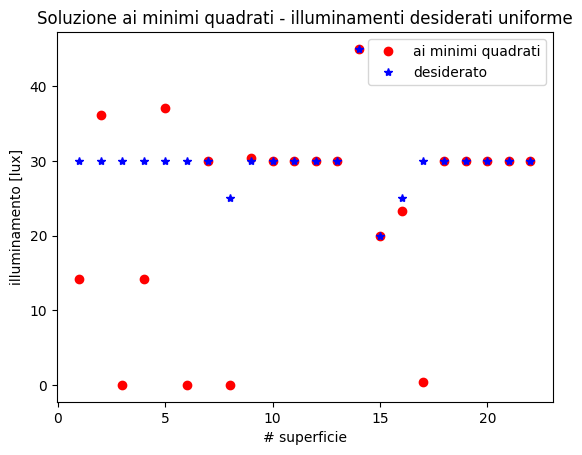



Superfici sottoilluminate: 
1 [-3.9464  0.1772 14.1938] : errore -52.931548066089306 %
3 [ 1.8305 12.8191 11.3535] : errore -100.0 %
4 [12.4989 15.6434  7.9006] : errore -52.54764927800315 %
6 [ 0.3038 -4.1824  8.602 ] : errore -100.0 %
8 [ 5.5175 15.593   9.009 ] : errore -100.0 %
17 [ 4.532  -0.1425 19.1346] : errore -98.52999580139529 %


Superfici sovrailluminate: 
2 [-1.9132  8.4809  9.2178] : errore 20.649883410634143 %
5 [13.492   9.5727  8.0744] : errore 23.798184594179947 %




' Altri due approcci che si potevano adottare per verificare il funzionamento del metodo in presenza di un numero ridotto di faretti era\n1) Rimuovere contemporaneamente faretto e superficie corrispondenti, in modo logico tali da mantenere la superficie esterna complessivamente illuminata.\n2) Porre tendenti a 0 le efficienze dei faretti che sono spenti, "ingannando" il metodo stesso. '

In [4]:
# --- versione ai MINIMI QUADRATI (Parte 1) ---

from scipy.linalg import solve

# # Decido manualmente quali faretti tenere e modifico la matrice A quadrata in rettangolare (mxn)

# Nell'ortofoto dall'alto i faretti (così come le superfici) partono da 1: to_keep = [2,5,7,9,10,11,12,13,14,15,16,18,19,20,21,22] # 16 faretti accesi su 22 totali
# Sottraggo 1 agli indici e ottengo quelli del codice:

to_keep = []
to_keep = [1,4,6,8,9,10,11,12,13,14,15,17,18,19,20,21]

A_red = A[:,to_keep]
print(A_red, '\n')

# --- versione con illuminamento uniforme sulla superficie --- b1

b = illuminamenti_desiderati

# Restituisce il vettore soluzione I Risolve il sistema lineare A(T)*A*I= A(T)*L che è un sistema quadrato (bene per GS) però ottenuto modificando i dati di partenza (A, L), e quindi non viene come nel caso iniziale
sol_red = solve(A_red.T@A_red, A_red.T@b)

# Restituisce il vettore degli illuminamenti che si ottengono con questa approssimazione, diversi da quelli che desideriamo.
ill_red = A_red@sol_red

print("Potenza dei faretti tenuti [W]: ", pd.DataFrame(sol_red, index=range(1, len(sol_red)+1)), "\n")
print("Potenza dei faretti se li uso tutti [W]: ", pd.DataFrame(soluzione_gs, index=range(1, len(soluzione_gs)+1)), "\n")

print("Illuminamento imperfetto [lux]: ", pd.DataFrame(ill_red, index=range(1, len(ill_red)+1)), "\n")
print("Illuminamento desiderato [lux]: ", pd.DataFrame(b, index=range(1, len(b)+1)), "\n")

n = len(ill_red)
xvect = range(1, n+1)

# Stampa il grafico degli illuminamenti imperfetti (approssimati ai minimi quadrati, ma con meno faretti accesi)
plt.plot(xvect, ill_red, 'ro')

# Stampa il grafico degli illuminamenti desiderati
plt.plot(xvect, b, 'b*')

plt.legend(['ai minimi quadrati','desiderato'])
plt.title('Soluzione ai minimi quadrati - illuminamenti desiderati uniforme')
plt.xlabel('# superficie')
plt.ylabel('illuminamento [lux]')
plt.show()

print('\n')
j=1

# --- Analisi delle superfici SOTTO-ILLUMINATE ---

print('Superfici sottoilluminate: ')

# Calcolo l'errore relativo dell'illuminamento (-1 <= err_ill <= 1)
err_ill = (ill_red - b)/b

# Verifico quali sono le superfici sotto-illuminate TANTO, oltre il 50%, cioè quelle il cui errore relativo è minore di -0.5
for s,e in zip(superfici,err_ill):
  if e<-0.5:

    # Stampa la coordinata del centroide della superficie che è sottoilluminata E l'errore relativo associato
    print(j, s['centroide'], ': errore', e*100,'%')
  j += 1

print('\n')
j=1

# --- Analisi delle superfici SOVRA-ILLUMINATE ---

print('Superfici sovrailluminate: ')
for s,e in zip(superfici,err_ill):

  # Verifico quali sono le superfici sovra-illuminate più del 10% della quantità richiesta
  if e>0.1:
    print(j, s['centroide'], ': errore', e*100,'%')
  j += 1

print('\n')



[[0.07202128 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.18461112 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.06950969 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]
 [0.         0.15348106 0.         0.         0.         0.         0.         0.         0.         0.         0.15644674 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         0.         0.         0.  

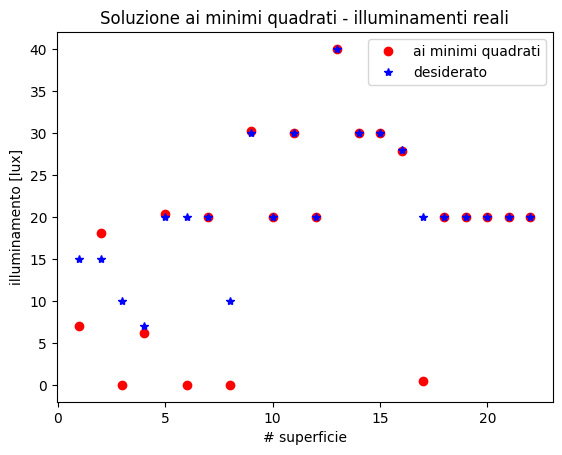



Superfici sottoilluminate: 
1 [-3.9464  0.1772 14.1938] : errore -52.931548066089306 %
3 [ 1.8305 12.8191 11.3535] : errore -100.0 %
6 [ 0.3038 -4.1824  8.602 ] : errore -100.0 %
8 [ 5.5175 15.593   9.009 ] : errore -100.0 %
17 [ 4.532  -0.1425 19.1346] : errore -97.80549396541043 %


Superfici sovrailluminate: 
2 [-1.9132  8.4809  9.2178] : errore 20.649883410634143 %


In [5]:
# --- versione ai MINIMI QUADRATI (Parte 2) ---

from scipy.linalg import solve
to_keep = []

to_keep = [1,4,6,8,9,10,11,12,13,14,15,17,18,19,20,21]
A_red = A[:,to_keep]

print(A_red, '\n')

# --- versione (buona) con illuminamento non uniforme sulla superficie --- b2

b = illuminamenti_reali
sol_red = solve(A_red.T@A_red, A_red.T@b)
ill_red = A_red@sol_red


print("Potenza dei faretti tenuti [W]: ", pd.DataFrame(sol_red, index=range(1, len(sol_red)+1)), "\n")
print("Potenza dei faretti se li uso tutti [W]: ", pd.DataFrame(soluzione_gs2, index=range(1, len(soluzione_gs)+1)), "\n")

print("Illuminamento imperfetto [lux]: ", pd.DataFrame(ill_red, index=range(1, len(ill_red)+1)), "\n")
print("Illuminamento desiderato [lux]: ", pd.DataFrame(b, index=range(1, len(b)+1)), "\n")

n = len(ill_red)
xvect = range(1, n+1)

plt.plot(xvect, ill_red, 'ro')
plt.plot(xvect, b, 'b*')

plt.legend(['ai minimi quadrati','desiderato'])
plt.title('Soluzione ai minimi quadrati - illuminamenti reali')
plt.xlabel('# superficie')
plt.ylabel('illuminamento [lux]')
plt.show()


print('\n')
j=1

# --- Analisi delle superfici SOTTO-ILLUMINATE ---

print('Superfici sottoilluminate: ')

# Calcolo l'errore relativo dell'illuminamento (-1 <= err_ill <= 1)
err_ill = (ill_red - b)/b
for s,e in zip(superfici,err_ill):

  # Verifico quali sono le superfici sotto-illuminate TANTO, oltre il 50%, cioè quelle il cui errore relativo è minore di -0.5
  if e<-0.5:

    # Stampa la coordinata del centroide della superficie che è sottoilluminata E l'errore relativo
    print(j, s['centroide'], ': errore', e*100,'%')
  j += 1

print('\n')
j=1

# --- Analisi delle superfici SOVRA-ILLUMINATE ---

print('Superfici sovrailluminate: ')
for s,e in zip(superfici,err_ill):

  # Verifico quali sono le superfici sovra-illuminate più del 10% della quantità richiesta
  if e>0.1:
    print(j, s['centroide'], ': errore', e*100,'%')
  j += 1

